In [1]:
from IPython.display import HTML
import random

def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'Toggle show/hide'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)
hide_toggle()

### Add 'hide_toggle()' in the cell to collapse

## Import Libraries

In [2]:
import numpy as np
import os, requests
from matplotlib import pyplot as plt
hide_toggle()

## Import plot functions and define parameters

In [3]:
# import matplotlib and set defaults
from matplotlib import rcParams 
from matplotlib import pyplot as plt
rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True
hide_toggle()

## Load data

In [4]:
# Load Data
fname = []
for j in range(3):
    fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
    if not os.path.isfile(fname[j]):
        try:
            r = requests.get(url[j])
        except requests.ConnectionError:
            print("!!! Failed to download data !!!")
        else:        
            if r.status_code != requests.codes.ok:
                print("!!! Failed to download data !!!")
            else:
                with open(fname[j], "wb") as fid:
                    fid.write(r.content)
hide_toggle()

In [5]:
# Data loading
alldat = np.array([])
for j in range(len(fname)):
    alldat = np.hstack((alldat, np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))

# select just one of the recordings here. 11 is nice because it has some neurons in vis ctx.
dat = alldat[11]
print(dat.keys())

dict_keys(['spks', 'wheel', 'pupil', 'lfp', 'response', 'response_time', 'bin_size', 'stim_onset', 'contrast_right', 'contrast_left', 'brain_area', 'brain_area_lfp', 'feedback_time', 'feedback_type', 'gocue', 'mouse_name', 'date_exp', 'trough_to_peak', 'waveform_w', 'waveform_u', 'active_trials', 'contrast_left_passive', 'contrast_right_passive', 'spks_passive', 'lfp_passive', 'pupil_passive', 'wheel_passive'])


## Group brain regions

In [6]:
# groupings of brain regions
regions = ["vis ctx", "thal", "hipp", "other ctx", "midbrain", "basal ganglia", "cortical subplate", "other"]
brain_groups = [["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"], # visual cortex
                ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"], # thalamus
                ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"], # hippocampal
                ["ACA", "AUD", "COA", "DP", "ILA", "MOp", "MOs", "OLF", "ORB", "ORBm", "PIR", "PL", "SSp", "SSs", "RSP"," TT"], # non-visual cortex
                ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"], # midbrain
                ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"], # basal ganglia 
                ["BLA", "BMA", "EP", "EPd", "MEA"] # cortical subplate
                ]

nareas = 4 # only the top 4 regions are in this particular mouse
NN = len(dat['brain_area']) # number of neurons
barea = nareas * np.ones(NN, ) # last one is "other"
for j in range(nareas):
    barea[np.isin(dat['brain_area'], brain_groups[j])] = j # assign a number to each region

## Plot: mean neural activity vs response

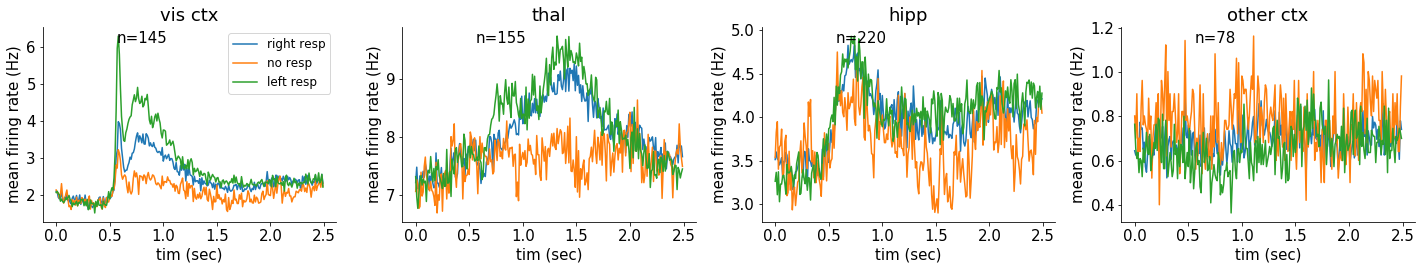

In [7]:
# plots by brain region and responses
dt = dat['bin_size'] # binning at 10 ms
NT = dat['spks'].shape[-1]
response = dat['response'] # right - nogo - left (-1, 0, 1)
for j in range(nareas):
    ax = plt.subplot(1,nareas,j+1)
    
    plt.plot(dt * np.arange(NT), 1/dt *  dat['spks'][barea==j][:,response>=0].mean(axis=(0,1)))
    plt.plot(dt * np.arange(NT), 1/dt *  dat['spks'][barea==j][:,response==0].mean(axis=(0,1)))
    plt.plot(dt * np.arange(NT), 1/dt *  dat['spks'][barea==j][:,response<0].mean(axis=(0,1)))  
    plt.text(.25, .92, 'n=%d'%np.sum(barea==j), transform=ax.transAxes)
    
    if j==0:
        plt.legend(['right resp','no resp', 'left resp'], fontsize=12)
    ax.set(xlabel = 'tim (sec)', ylabel = 'mean firing rate (Hz)', title = regions[j])
hide_toggle()

## Plot: mean neural activity vs task difficulty

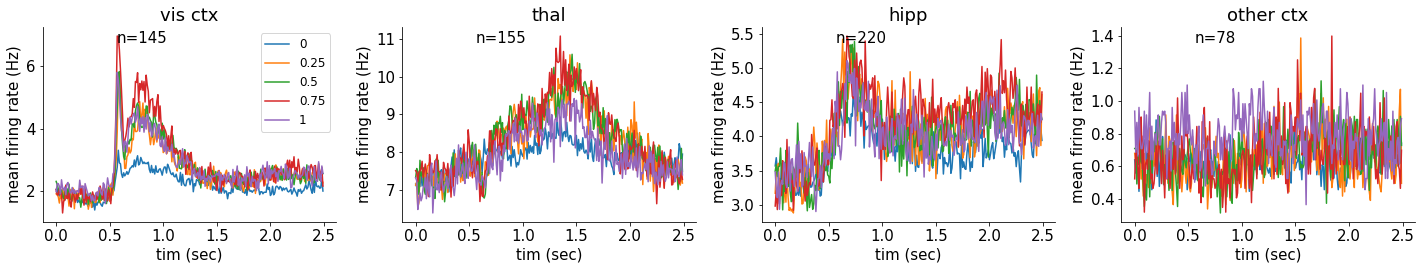

In [8]:
dt = dat['bin_size'] # binning at 10 ms
NT = dat['spks'].shape[-1]

l_cont = dat['contrast_left']
r_cont = dat['contrast_right']

for j in range(nareas):
    ax = plt.subplot(1,nareas,j+1)
    
    plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:,np.abs(l_cont-r_cont)==0][barea==j].mean(axis=(0,1))) # difference 0
    plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:,np.abs(l_cont-r_cont)==0.25][barea==j].mean(axis=(0,1))) # difference 0.25
    plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:,np.abs(l_cont-r_cont)==0.5][barea==j].mean(axis=(0,1))) # difference 0.5
    plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:,np.abs(l_cont-r_cont)==0.75][barea==j].mean(axis=(0,1))) # difference 0.75
    plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:,np.abs(l_cont-r_cont)==1][barea==j].mean(axis=(0,1))) # difference 1
  
    plt.text(.25, .92, 'n=%d'%np.sum(barea==j), transform=ax.transAxes)

    if j==0:
        plt.legend(['0', '0.25', '0.5', '0.75', '1'], fontsize=12)
    ax.set(xlabel = 'tim (sec)', ylabel = 'mean firing rate (Hz)', title = regions[j])
hide_toggle()

------------------------------------------------------------------------------------------------------------

# Encoding - Variables 

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from scipy import stats


def global_regression_with_past(session, region, key):
    
    def x_variables_across_all_sessions_with_past(session):
        i = session
        dat = alldat[i]
        #pupil data
        dat['pupil'].shape #  (3, 340, 250) <-- (pupil area, pupil horizontal, pupil vertical), 250 time bins, 340 trials
        pupil_area = dat['pupil'][0,:,:]
        pupil_area_T = np.transpose(pupil_area)
        current_pupil_area = np.sum(pupil_area_T, axis=0)
        current_pupil_area_z = stats.zscore(current_pupil_area)

        #choice left, nogo, right
        choice = dat['response']
        choice_z = stats.zscore(choice)
        
        #Current reward received or not received (correct choice)
        current_reward = dat['feedback_type']
        current_reward_z = stats.zscore(current_reward)
        
        #Past reward
        past_reward = np.roll(current_reward, 1)
        past_reward_z = stats.zscore(past_reward)
        
        ##Trial difficulty
        l_cont = dat['contrast_left']
        r_cont = dat['contrast_right']
        
        arr = np.array([l_cont,r_cont])
        contrast = np.stack(arr)
        #current contrast trial difficulty
        contrast_difference = contrast[0,:] - contrast[1,:]
        current_contrast_difference = np.abs(contrast_difference)
        current_contrast_difference_z = stats.zscore(current_contrast_difference)
        #past contrast trial difficulty
        past_contrast_difference = np.roll(current_contrast_difference, 1)
        past_contrast_difference_z = stats.zscore(past_contrast_difference)
        #sum of current trial contrast
        current_contrast_sum = contrast[0,:] + contrast[1,:]
        current_contrast_sum_z = stats.zscore(current_contrast_sum)
        #sum of previous trial contrast
        past_contrast_sum = np.roll(current_contrast_sum, 1)
        past_contrast_sum_z = stats.zscore(past_contrast_sum)       
        #sum accounts for what is already explained by the contrast
        
        features = np.array([current_pupil_area_z, choice_z, current_reward_z, past_reward_z, current_contrast_difference_z, past_contrast_difference_z, current_contrast_sum_z, past_contrast_sum_z])
        features = np.transpose(features)
        
        return features
    
    def y_variables_across_all_sessions(session, region):
        #spikes / Neuronal data
        #region 1-4
        i = session
        dat = alldat[i]
        
        nareas = 4 # only the top 4 regions are in this particular mouse
        NN = len(dat['brain_area']) # number of neurons
        barea = nareas * np.ones(NN, ) # last one is "other"
        for j in range(nareas):
            barea[np.isin(dat['brain_area'], brain_groups[j])] = j
        
        #spikes / Neuronal data
        spikes_per_region = dat['spks'][barea==region].mean(axis=(0))
        pop_spikes_per_region_T = np.transpose(spikes_per_region)
        pop_spikes_per_region = np.sum(pop_spikes_per_region_T, axis=0)
        pop_spikes_per_region_z = stats.zscore(pop_spikes_per_region)
        
        return pop_spikes_per_region_z
    
    def polynomialregression_with_past(session, region, key):
        #step 1: provide data
        i = session
        r = region
        X = x_variables_across_all_sessions_with_past(i)
        y = y_variables_across_all_sessions(i, r)
        
        #step 2: transform input data X
        X_ = PolynomialFeatures(degree=1, include_bias=False).fit_transform(X)
        
        #step 3: Create a model and fit it
        model = LinearRegression().fit(X_, y)
        #polyfit vs fit
        
        #step 4: Get results
        r_sq = model.score(X_, y) #.score() returns 𝑅²
        
        #step 5: Predict the response
        y_pred = model.predict(X_)
        #print('predicted response:', y_pred, sep='\n')
        
        #Predict the response **Alternative**
        #Mean
        #y_pred = model.intercept_ + np.sum(model.coef_ * X_, axis=1)
        #print('predicted response:', y_pred, sep='\n')
        results = {'y_pred': y_pred, 'y': y, 'X_': X_, 'r_sq': r_sq, 'intercept': model.intercept_, 'coefficient': model.coef_}    
        
        return results[key]

    return polynomialregression_with_past(session, region, key)



In [10]:
#global_regression_with_past(2, 4, 'r_sq')

In [11]:
def global_regression_without_past(session, region, key):
    
    def x_variables_across_all_sessions_without_past(session):
        i = session
        dat = alldat[i]
        #pupil data
        dat['pupil'].shape #  (3, 340, 250) <-- (pupil area, pupil horizontal, pupil vertical), 250 time bins, 340 trials
        pupil_area = dat['pupil'][0,:,:]
        pupil_area_T = np.transpose(pupil_area)
        current_pupil_area = np.sum(pupil_area_T, axis=0)
        current_pupil_area_z = stats.zscore(current_pupil_area)

        #choice left, nogo, right
        choice = dat['response']
        choice_z = stats.zscore(choice)
    
        #Current reward received or not received (correct choice)
        current_reward = dat['feedback_type']
        current_reward_z = stats.zscore(current_reward)

        #Past reward
        #past_reward = np.roll(current_reward, 1)
    
        ##Trial difficulty
        l_cont = dat['contrast_left']
        r_cont = dat['contrast_right']

        arr = np.array([l_cont,r_cont])
        contrast = np.stack(arr)
        #current contrast trial difficulty
        contrast_difference = contrast[0,:] - contrast[1,:]
        current_contrast_difference = np.abs(contrast_difference)
        current_contrast_difference_z = stats.zscore(current_contrast_difference)
        #past contrast trial difficulty
        #past_contrast_difference = np.roll(current_contrast_difference, 1)
        
        #future contrast difference
        #future_contrast_difference = np.roll(current_contrast_difference, -1)
        #future_contrast_difference_z = stats.zscore(future_contrast_difference)
        
        #sum of current trial contrast
        current_contrast_sum = contrast[0,:] + contrast[1,:]
        current_contrast_sum_z = stats.zscore(current_contrast_sum)
        #sum of previous trial contrast
        #past_contrast_sum = np.roll(current_contrast_sum, 1)
        #sum accounts for what is already explained by the contrast
    
        features = np.array([current_pupil_area_z, choice_z, current_reward_z, current_contrast_difference_z, current_contrast_sum_z])
        features = np.transpose(features)

        return features
    
    def y_variables_across_all_sessions(session, region):
        #spikes / Neuronal data
        #region 1-4
        i = session
        dat = alldat[i]
        
        nareas = 4 # only the top 4 regions are in this particular mouse
        NN = len(dat['brain_area']) # number of neurons
        barea = nareas * np.ones(NN, ) # last one is "other"
        for j in range(nareas):
            barea[np.isin(dat['brain_area'], brain_groups[j])] = j
        
        #spikes / Neuronal data
        spikes_per_region = dat['spks'][barea==region].mean(axis=(0))
        pop_spikes_per_region_T = np.transpose(spikes_per_region)
        pop_spikes_per_region = np.sum(pop_spikes_per_region_T, axis=0)
        pop_spikes_per_region_z = stats.zscore(pop_spikes_per_region)
        
        return pop_spikes_per_region_z
    
    def polynomialregression_without_past(session, region, key):
        #step 1: provide data    
        i = session
        r = region
        X = x_variables_across_all_sessions_without_past(i)
        y = y_variables_across_all_sessions(i, r)
    
        #step 2: transform input data X
        X_ = PolynomialFeatures(degree=1, include_bias=False).fit_transform(X)
    
    
        #step 3: Create a model and fit it    
        model = LinearRegression().fit(X_, y)
        #polyfit vs fit

    
        #step 4: Get results
        r_sq = model.score(X_, y) #.score() returns 𝑅²
            #print(f"𝑅² - coefficient of determination: {r_sq}", f"intercept: {model.intercept_}", f"coefficients: {model.coef_}")    #.intercept_, which represents the coefficient, 𝑏₀  
        #print('𝑅²-coefficient of determination:', r_sq)
        #print('intercept:', model.intercept_)
        #print('coefficients:', model.coef_)
        #.intercept_, which represents the coefficient, 𝑏₀
        #.coef_, which represents 𝑏₁
    
        #step 5: Predict the response
        y_pred = model.predict(X_)
        #print('predicted response:', y_pred, sep='\n')
    
        #Predict the response **Alternative**
        #Mean
        #y_pred = model.intercept_ + np.sum(model.coef_ * X_, axis=1)
        #print('predicted response:', y_pred, sep='\n')
        
        results = {'y_pred': y_pred, 'y': y, 'X_': X_, 'r_sq': r_sq, 'intercept': model.intercept_, 'coefficient': model.coef_}
    
        return results[key]

    return polynomialregression_without_past(session, region, key)

In [12]:
#global_regression_without_past(2, 4, 'r_sq')
#global_regression_without_past(0, 0, 'r_sq') + global_regression_without_past(0, 0, 'r_sq')
#print(global_regression_with_past.key())
#print(global_regression_with_past(11, 0, 'r_sq'))
#print(global_regression_without_past(11,0, 'coefficient'))

def sort_length_session(length):
    session = np.arange(length)
    r_sq = np.zeros(length)
    for i in session:
        r_sq[i] = global_regression_with_past(i, 0, 'coefficient')

#sort_length_session(2)
#global_regression_with_past(11, 0, 'coefficient')

In [13]:
session = np.arange(3)
r_sq = np.zeros(3)
for i in session:
    r_sq[i] = global_regression_with_past(i, 0, 'r_sq')

# Regression Plots

Average Visual Cortex Response

In [14]:
#session 3, 7, 8, 11, 12. 26, 27, 29, 34, 38

In [15]:
vis_cortex_r_sq_all_sessions_with_past = np.array([global_regression_with_past(0, 0, 'r_sq'),
                                              global_regression_with_past(1, 0, 'r_sq'),
                                              global_regression_with_past(2, 0, 'r_sq'),
                                              global_regression_with_past(3, 0, 'r_sq'),
                                              global_regression_with_past(4, 0, 'r_sq'),
                                              global_regression_with_past(7, 0, 'r_sq'),
                                              global_regression_with_past(8, 0, 'r_sq'),
                                              global_regression_with_past(9, 0, 'r_sq'),
                                              global_regression_with_past(11, 0, 'r_sq'),
                                              global_regression_with_past(12, 0, 'r_sq'),
                                              global_regression_with_past(13, 0, 'r_sq'),
                                              global_regression_with_past(18, 0, 'r_sq'),
                                              global_regression_with_past(19, 0, 'r_sq'),
                                              global_regression_with_past(21, 0, 'r_sq'),
                                              global_regression_with_past(22, 0, 'r_sq'),
                                              global_regression_with_past(23, 0, 'r_sq'),
                                              global_regression_with_past(24, 0, 'r_sq'),
                                              global_regression_with_past(25, 0, 'r_sq'),
                                              global_regression_with_past(26, 0, 'r_sq'),
                                              global_regression_with_past(27, 0, 'r_sq'),
                                              global_regression_with_past(29, 0, 'r_sq'),
                                              global_regression_with_past(34, 0, 'r_sq'),
                                              global_regression_with_past(35, 0, 'r_sq'),
                                              global_regression_with_past(36, 0, 'r_sq'),
                                              global_regression_with_past(38, 0, 'r_sq')])

average_vis_cortex_r_sq_all_sessions_with_past = np.mean(vis_cortex_r_sq_all_sessions_with_past)
std_vis_cortex_r_sq_all_sessions_with_past = np.std(vis_cortex_r_sq_all_sessions_with_past)
#average_vis_cortex_all_sessions_with_past
#print(average_vis_cortex_all_sessions_with_past, vis_cortex_all_sessions_with_past)

vis_cortex_r_sq_all_sessions_without_past = np.array([global_regression_without_past(0, 0, 'r_sq'),
                                                 global_regression_without_past(1, 0, 'r_sq'),
                                                 global_regression_without_past(2, 0, 'r_sq'),
                                                 global_regression_without_past(3, 0, 'r_sq'),
                                                 global_regression_without_past(4, 0, 'r_sq'),
                                                 global_regression_without_past(7, 0, 'r_sq'),
                                                 global_regression_without_past(8, 0, 'r_sq'),
                                                 global_regression_without_past(9, 0, 'r_sq'),
                                                 global_regression_without_past(11, 0, 'r_sq'),
                                                 global_regression_without_past(12, 0, 'r_sq'),
                                                 global_regression_without_past(13, 0, 'r_sq'),
                                                 global_regression_without_past(18, 0, 'r_sq'),
                                                 global_regression_without_past(19, 0, 'r_sq'),
                                                 global_regression_without_past(21, 0, 'r_sq'),
                                                 global_regression_without_past(22, 0, 'r_sq'),
                                                 global_regression_without_past(23, 0, 'r_sq'),
                                                 global_regression_without_past(24, 0, 'r_sq'),
                                                 global_regression_without_past(25, 0, 'r_sq'),
                                                 global_regression_without_past(26, 0, 'r_sq'),
                                                 global_regression_without_past(27, 0, 'r_sq'),
                                                 global_regression_without_past(29, 0, 'r_sq'),
                                                 global_regression_without_past(34, 0, 'r_sq'),
                                                 global_regression_without_past(35, 0, 'r_sq'),
                                                 global_regression_without_past(36, 0, 'r_sq'),
                                                 global_regression_without_past(38, 0, 'r_sq')])

average_vis_cortex_r_sq_all_sessions_without_past = np.mean(vis_cortex_r_sq_all_sessions_without_past)
std_vis_cortex_r_sq_all_sessions_without_past = np.std(vis_cortex_r_sq_all_sessions_without_past)

#average_vis_cortex_all_sessions_without_past
#print(average_vis_cortex_all_sessions_without_past, vis_cortex_all_sessions_without_past)

print(average_vis_cortex_r_sq_all_sessions_without_past, average_vis_cortex_r_sq_all_sessions_with_past)
#print('std Visual Cortex with and without past')
print(std_vis_cortex_r_sq_all_sessions_without_past, std_vis_cortex_r_sq_all_sessions_with_past)

hide_toggle()

0.2619352077120321 0.2812556424193731
0.1537445144941598 0.15291919312041838


Average Thalamus

In [16]:
#r_sq values across all sessions with and without past
thalamus_r_sq_all_sessions_with_past = np.array([global_regression_with_past(2, 1, 'r_sq'),
                                            global_regression_with_past(3, 1, 'r_sq'),
                                            global_regression_with_past(5, 1, 'r_sq'),
                                            global_regression_with_past(6, 1, 'r_sq'),
                                            global_regression_with_past(7, 1, 'r_sq'),
                                            global_regression_with_past(8, 1, 'r_sq'),
                                            global_regression_with_past(9, 1, 'r_sq'),
                                            global_regression_with_past(10, 1, 'r_sq'),
                                            global_regression_with_past(11, 1, 'r_sq'),
                                            global_regression_with_past(12, 1, 'r_sq'),
                                            global_regression_with_past(14, 1, 'r_sq'),
                                            global_regression_with_past(15, 1, 'r_sq'),
                                            global_regression_with_past(16, 1, 'r_sq'),
                                            global_regression_with_past(17, 1, 'r_sq'),
                                            global_regression_with_past(18, 1, 'r_sq'),
                                            global_regression_with_past(19, 1, 'r_sq'),
                                            global_regression_with_past(20, 1, 'r_sq'),
                                            global_regression_with_past(22, 1, 'r_sq'),
                                            global_regression_with_past(26, 1, 'r_sq'),
                                            global_regression_with_past(27, 1, 'r_sq'),
                                            global_regression_with_past(29, 1, 'r_sq'),
                                            global_regression_with_past(30, 1, 'r_sq'),
                                            global_regression_with_past(32, 1, 'r_sq'),
                                            global_regression_with_past(33, 1, 'r_sq'),
                                            global_regression_with_past(34, 1, 'r_sq'),
                                            global_regression_with_past(37, 1, 'r_sq'),
                                            global_regression_with_past(38, 1, 'r_sq')])

average_thalamus_r_sq_all_sessions_with_past = np.mean(thalamus_r_sq_all_sessions_with_past)
std_thalamus_r_sq_all_sessions_with_past = np.std(thalamus_r_sq_all_sessions_with_past)
#average_thalamus_all_sessions_with_past
#print(average_thalamus_all_sessions_with_past, thalamus_all_sessions_with_past)

thalamus_r_sq_all_sessions_without_past = np.array([global_regression_without_past(2, 1, 'r_sq'),
                                               global_regression_without_past(3, 1, 'r_sq'),
                                               global_regression_without_past(5, 1, 'r_sq'),
                                               global_regression_without_past(6, 1, 'r_sq'),
                                               global_regression_without_past(7, 1, 'r_sq'),
                                               global_regression_without_past(8, 1, 'r_sq'),
                                               global_regression_without_past(9, 1, 'r_sq'),
                                               global_regression_without_past(10, 1, 'r_sq'),
                                               global_regression_without_past(11, 1, 'r_sq'),
                                               global_regression_without_past(12, 1, 'r_sq'),
                                               global_regression_without_past(14, 1, 'r_sq'),
                                               global_regression_without_past(15, 1, 'r_sq'),
                                               global_regression_without_past(16, 1, 'r_sq'),
                                               global_regression_without_past(17, 1, 'r_sq'),
                                               global_regression_without_past(18, 1, 'r_sq'),
                                               global_regression_without_past(19, 1, 'r_sq'),
                                               global_regression_without_past(20, 1, 'r_sq'),
                                               global_regression_without_past(22, 1, 'r_sq'),
                                               global_regression_without_past(26, 1, 'r_sq'),
                                               global_regression_without_past(27, 1, 'r_sq'),
                                               global_regression_without_past(29, 1, 'r_sq'),
                                               global_regression_without_past(30, 1, 'r_sq'),
                                               global_regression_without_past(32, 1, 'r_sq'),
                                               global_regression_without_past(33, 1, 'r_sq'),
                                               global_regression_without_past(34, 1, 'r_sq'),
                                               global_regression_without_past(37, 1, 'r_sq'),
                                               global_regression_without_past(38, 1, 'r_sq')])

average_thalamus_r_sq_all_sessions_without_past = np.mean(thalamus_r_sq_all_sessions_without_past)
std_thalamus_r_sq_all_sessions_without_past = np.std(thalamus_r_sq_all_sessions_without_past)
#average_thalamus_all_sessions_without_past
#print(average_thalamus_all_sessions_without_past, thalamus_all_sessions_without_past)

print(average_thalamus_r_sq_all_sessions_without_past, average_thalamus_r_sq_all_sessions_with_past)
print(std_thalamus_r_sq_all_sessions_without_past, std_thalamus_r_sq_all_sessions_with_past)


hide_toggle()

0.24442828730964378 0.29147177563416377
0.12439058184965125 0.12103893278764837


Average Hippocampus

In [17]:
#r_sq values across all sessions with and without past
hippocampus_r_sq_all_sessions_with_past = np.array([global_regression_with_past(0, 2, 'r_sq'),
                                               global_regression_with_past(1, 2, 'r_sq'),
                                               global_regression_with_past(2, 2, 'r_sq'),
                                               global_regression_with_past(3, 2, 'r_sq'),
                                               global_regression_with_past(4, 2, 'r_sq'),
                                               global_regression_with_past(5, 2, 'r_sq'),
                                               global_regression_with_past(6, 2, 'r_sq'),
                                               global_regression_with_past(7, 2, 'r_sq'),
                                               global_regression_with_past(8, 2, 'r_sq'),
                                               global_regression_with_past(9, 2, 'r_sq'),
                                               global_regression_with_past(11, 2, 'r_sq'),
                                               global_regression_with_past(12, 2, 'r_sq'),
                                               global_regression_with_past(13, 2, 'r_sq'),
                                               global_regression_with_past(14, 2, 'r_sq'),
                                               global_regression_with_past(15, 2, 'r_sq'),
                                               global_regression_with_past(17, 2, 'r_sq'),
                                               global_regression_with_past(18, 2, 'r_sq'),
                                               global_regression_with_past(19, 2, 'r_sq'),
                                               global_regression_with_past(22, 2, 'r_sq'),
                                               global_regression_with_past(23, 2, 'r_sq'),
                                               global_regression_with_past(26, 2, 'r_sq'),
                                               global_regression_with_past(27, 2, 'r_sq'),
                                               global_regression_with_past(29, 2, 'r_sq'),
                                               global_regression_with_past(30, 2, 'r_sq'),
                                               global_regression_with_past(32, 2, 'r_sq'),
                                               global_regression_with_past(34, 2, 'r_sq'),
                                               global_regression_with_past(35, 2, 'r_sq'),
                                               global_regression_with_past(37, 2, 'r_sq'),
                                               global_regression_with_past(38, 2, 'r_sq')])

average_hippocampus_r_sq_all_sessions_with_past = np.mean(hippocampus_r_sq_all_sessions_with_past)
std_hippocampus_r_sq_all_sessions_with_past = np.std(hippocampus_r_sq_all_sessions_with_past)
#average_hippocampus_all_sessions_with_past
#print(average_hippocampus_all_sessions_with_past, hippocampus_all_sessions_with_past)

hippocampus_r_sq_all_sessions_without_past = np.array([global_regression_without_past(0, 2, 'r_sq'),
                                                  global_regression_without_past(1, 2, 'r_sq'),
                                                  global_regression_without_past(2, 2, 'r_sq'),
                                                  global_regression_without_past(3, 2, 'r_sq'),
                                                  global_regression_without_past(4, 2, 'r_sq'),
                                                  global_regression_without_past(5, 2, 'r_sq'),
                                                  global_regression_without_past(6, 2, 'r_sq'),
                                                  global_regression_without_past(7, 2, 'r_sq'),
                                                  global_regression_without_past(8, 2, 'r_sq'),
                                                  global_regression_without_past(9, 2, 'r_sq'),
                                                  global_regression_without_past(11, 2, 'r_sq'),
                                                  global_regression_without_past(12, 2, 'r_sq'),
                                                  global_regression_without_past(13, 2, 'r_sq'),
                                                  global_regression_without_past(14, 2, 'r_sq'),
                                                  global_regression_without_past(15, 2, 'r_sq'),
                                                  global_regression_without_past(17, 2, 'r_sq'),
                                                  global_regression_without_past(18, 2, 'r_sq'),
                                                  global_regression_without_past(19, 2, 'r_sq'),
                                                  global_regression_without_past(22, 2, 'r_sq'),
                                                  global_regression_without_past(23, 2, 'r_sq'),
                                                  global_regression_without_past(26, 2, 'r_sq'),
                                                  global_regression_without_past(27, 2, 'r_sq'),
                                                  global_regression_without_past(29, 2, 'r_sq'),
                                                  global_regression_without_past(30, 2, 'r_sq'),
                                                  global_regression_without_past(32, 2, 'r_sq'),
                                                  global_regression_without_past(34, 2, 'r_sq'),
                                                  global_regression_without_past(35, 2, 'r_sq'),
                                                  global_regression_without_past(37, 2, 'r_sq'),
                                                  global_regression_without_past(38, 2, 'r_sq')])

average_hippocampus_r_sq_all_sessions_without_past = np.mean(hippocampus_r_sq_all_sessions_without_past)
std_hippocampus_r_sq_all_sessions_without_past = np.std(hippocampus_r_sq_all_sessions_without_past)

#average_hippocampus_all_sessions_with_past
#print(average_hippocampus_all_sessions_without_past, hippocampus_all_sessions_without_past)

print(average_hippocampus_r_sq_all_sessions_without_past, average_hippocampus_r_sq_all_sessions_with_past)
print(std_hippocampus_r_sq_all_sessions_without_past, std_hippocampus_r_sq_all_sessions_with_past)


hide_toggle()

0.15390889081058595 0.18161930274309485
0.09297713120799445 0.09661879138745945


Average Other Ctx

In [18]:
other_ctx_r_sq_all_sessions_with_past = np.array([global_regression_with_past(0, 3, 'r_sq'),
                                             global_regression_with_past(3, 3, 'r_sq'),
                                             global_regression_with_past(4, 3, 'r_sq'),
                                             global_regression_with_past(5, 3, 'r_sq'),
                                             global_regression_with_past(6, 3, 'r_sq'),
                                             global_regression_with_past(7, 3, 'r_sq'),
                                             global_regression_with_past(8, 3, 'r_sq'),
                                             global_regression_with_past(10, 3, 'r_sq'),
                                             global_regression_with_past(11, 3, 'r_sq'),
                                             global_regression_with_past(12, 3, 'r_sq'),
                                             global_regression_with_past(13, 3, 'r_sq'),
                                             global_regression_with_past(15, 3, 'r_sq'),
                                             global_regression_with_past(20, 3, 'r_sq'),
                                             global_regression_with_past(21, 3, 'r_sq'),
                                             global_regression_with_past(23, 3, 'r_sq'),
                                             global_regression_with_past(24, 3, 'r_sq'),
                                             global_regression_with_past(25, 3, 'r_sq'),
                                             global_regression_with_past(26, 3, 'r_sq'),
                                             global_regression_with_past(27, 3, 'r_sq'),
                                             global_regression_with_past(28, 3, 'r_sq'),
                                             global_regression_with_past(29, 3, 'r_sq'),
                                             global_regression_with_past(30, 3, 'r_sq'),
                                             global_regression_with_past(31, 3, 'r_sq'),
                                             global_regression_with_past(33, 3, 'r_sq'),
                                             global_regression_with_past(34, 3, 'r_sq'),
                                             global_regression_with_past(35, 3, 'r_sq'),
                                             global_regression_with_past(36, 3, 'r_sq'),
                                             global_regression_with_past(38, 3, 'r_sq')])

average_other_ctx_r_sq_all_sessions_with_past = np.mean(other_ctx_r_sq_all_sessions_with_past)
std_other_ctx_r_sq_all_sessions_with_past = np.std(other_ctx_r_sq_all_sessions_with_past)
#average_other_ctx_all_sessions_with_past
#print(average_other_ctx_all_sessions_with_past, other_ctx_all_sessions_with_past)

other_ctx_r_sq_all_sessions_without_past = np.array([global_regression_without_past(0, 3, 'r_sq'),
                                                global_regression_without_past(3, 3, 'r_sq'),
                                                global_regression_without_past(4, 3, 'r_sq'),
                                                global_regression_without_past(5, 3, 'r_sq'),
                                                global_regression_without_past(6, 3, 'r_sq'),
                                                global_regression_without_past(7, 3, 'r_sq'),
                                                global_regression_without_past(8, 3, 'r_sq'),
                                                global_regression_without_past(10, 3, 'r_sq'),
                                                global_regression_without_past(11, 3, 'r_sq'),
                                                global_regression_without_past(12, 3, 'r_sq'),
                                                global_regression_without_past(13, 3, 'r_sq'),
                                                global_regression_without_past(15, 3, 'r_sq'),
                                                global_regression_without_past(20, 3, 'r_sq'),
                                                global_regression_without_past(21, 3, 'r_sq'),
                                                global_regression_without_past(23, 3, 'r_sq'),
                                                global_regression_without_past(24, 3, 'r_sq'),
                                                global_regression_without_past(25, 3, 'r_sq'),
                                                global_regression_without_past(26, 3, 'r_sq'),
                                                global_regression_without_past(27, 3, 'r_sq'),
                                                global_regression_without_past(28, 3, 'r_sq'),
                                                global_regression_without_past(29, 3, 'r_sq'),
                                                global_regression_without_past(30, 3, 'r_sq'),
                                                global_regression_without_past(31, 3, 'r_sq'),
                                                global_regression_without_past(33, 3, 'r_sq'),
                                                global_regression_without_past(34, 3, 'r_sq'),
                                                global_regression_without_past(35, 3, 'r_sq'),
                                                global_regression_without_past(36, 3, 'r_sq'),
                                                global_regression_without_past(38, 3, 'r_sq')])

average_other_ctx_r_sq_all_sessions_without_past = np.mean(other_ctx_r_sq_all_sessions_without_past)
std_other_ctx_r_sq_all_sessions_without_past = np.std(other_ctx_r_sq_all_sessions_without_past)
#average_other_ctx_all_sessions_without_past
#print(average_other_ctx_all_sessions_without_past, other_ctx_all_sessions_without_past)

#print('average other ctx r_sq with and without past')
print(average_other_ctx_r_sq_all_sessions_without_past, average_other_ctx_r_sq_all_sessions_with_past)
print(std_other_ctx_r_sq_all_sessions_without_past, std_other_ctx_r_sq_all_sessions_with_past)

hide_toggle()

0.24331974659045946 0.28074721130389113
0.11293330290963274 0.11829634129590925


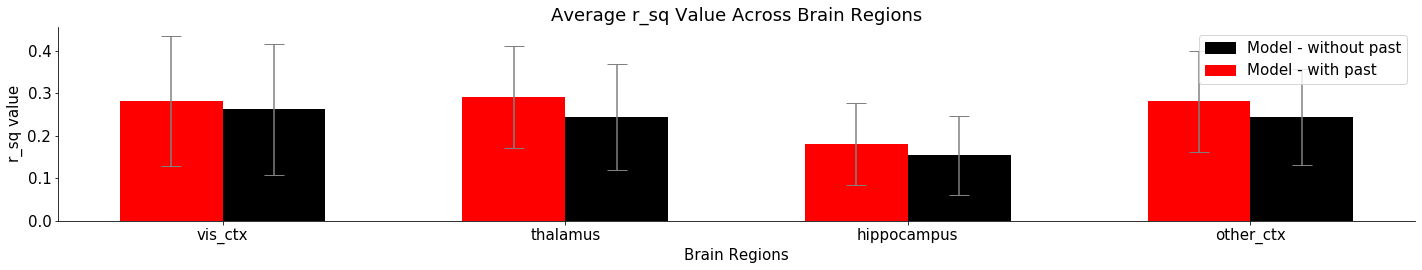

In [77]:
#works for average across all sessions
import matplotlib.patches as mpatches

values_with_past = [average_vis_cortex_r_sq_all_sessions_with_past, average_thalamus_r_sq_all_sessions_with_past, average_hippocampus_r_sq_all_sessions_with_past, average_other_ctx_r_sq_all_sessions_with_past]
values_without_past = [average_vis_cortex_r_sq_all_sessions_without_past, average_thalamus_r_sq_all_sessions_without_past, average_hippocampus_r_sq_all_sessions_without_past, average_other_ctx_r_sq_all_sessions_without_past]
error_with_past = [std_vis_cortex_r_sq_all_sessions_with_past, std_thalamus_r_sq_all_sessions_with_past, std_hippocampus_r_sq_all_sessions_with_past, std_other_ctx_r_sq_all_sessions_with_past]
error_without_past = [std_vis_cortex_r_sq_all_sessions_without_past, std_thalamus_r_sq_all_sessions_without_past, std_hippocampus_r_sq_all_sessions_without_past, std_other_ctx_r_sq_all_sessions_without_past]

#print(average_hippocampus_r_sq_all_sessions_without_past, average_hippocampus_r_sq_all_sessions_with_past)


names = ['vis_ctx', 'thalamus', 'hippocampus', 'other_ctx']

x = np.arange(len(values_with_past))

fig, ax = plt.subplots()
bar_width = 0.3
reacts1 = ax.bar(x, values_with_past, width=bar_width, color='red', yerr=error_with_past, ecolor='grey', capsize=10)
reacts2 = ax.bar(x + bar_width, values_without_past, width=bar_width, color='black', yerr=error_without_past, ecolor='grey', capsize=10)

#plt.xticks(x, names)
plt.xticks(x + bar_width/2, names)
plt.title('Average r_sq Value Across Brain Regions')
plt.xlabel('Brain Regions')
plt.ylabel('r_sq value')

#plt.errorbar(x, y, e, linestyle='None', marker='^')

red_patch = mpatches.Patch(color = 'red', label = 'Model - with past')
black_patch = mpatches.Patch(color = 'black', label = 'Model - without past')
plt.legend(handles = [black_patch, red_patch], loc='upper right')

#def autolabel(rects):
#    """Attach a text label above each bar in *rects*, displaying its height."""
#    for rect in rects:
#        height = rect.get_height()
#        ax.annotate('{}'.format(height),
#                    xy=(rect.get_x() + rect.get_width() / 2, height),
#                    xytext=(0, 3),  # 3 points vertical offset
#                    textcoords="offset points",
#                    ha='center', va='bottom')
#autolabel(reacts1)
#autolabel(reacts2)

#plt.grid(axis='y')
#plt.subplot(131)
#plt.bar(names, values)
#plt.title('Regional r_sq Across Regions w/ Past')
#plt.subplot(132)
#plt.bar(names2, values2)
#plt.title('Regional r_sq Across Regions w/o Past')
plt.show()

In [75]:
def coefficient_values_with_past_def(key, region):
    coefficient_values_with_past = global_regression_with_past(11, 0, key)
    coefficient_values_with_past[region]

#pupil_area_with_past = coefficient_values_with_past[0]
#choice_with_past = coefficient_values_with_past[1]
#current_reward_with_past = coefficient_values_with_past[2]
#past_reward_with_past = coefficient_values_with_past[3]
#current_trial_contrast_difference_with_past = coefficient_values_with_past[4]
#past_trial_contrast_difference_with_past = coefficient_values_with_past[5]
#current_trial_contrast_sum_with_past = coefficient_values_with_past[6]
#past_trial_contrast_sum_with_past = coefficient_values_with_past[7]


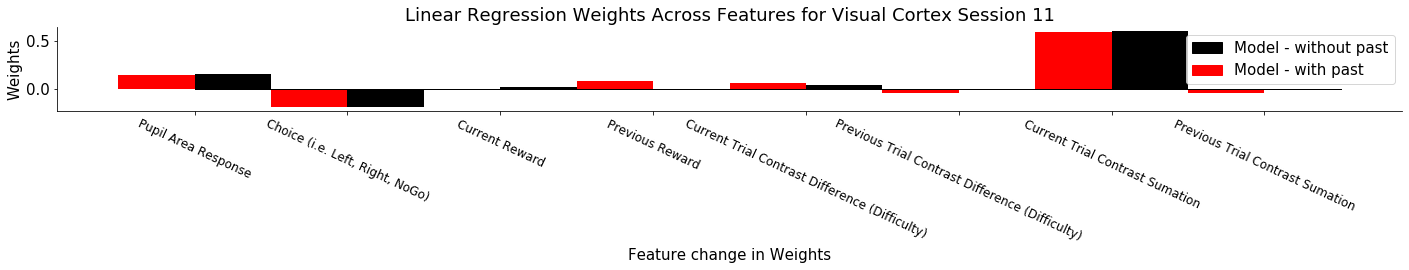

In [132]:
vis_ctx_coefficient_values_with_past = global_regression_with_past(11, 0, 'coefficient')

vis_ctx_pupil_area_with_past = vis_ctx_coefficient_values_with_past[0]
vis_ctx_choice_with_past = vis_ctx_coefficient_values_with_past[1]
vis_ctx_current_reward_with_past = vis_ctx_coefficient_values_with_past[2]
vis_ctx_past_reward_with_past = vis_ctx_coefficient_values_with_past[3]
vis_ctx_current_trial_contrast_difference_with_past = vis_ctx_coefficient_values_with_past[4]
vis_ctx_past_trial_contrast_difference_with_past = vis_ctx_coefficient_values_with_past[5]
vis_ctx_current_trial_contrast_sum_with_past = vis_ctx_coefficient_values_with_past[6]
vis_ctx_past_trial_contrast_sum_with_past = vis_ctx_coefficient_values_with_past[7]


vis_ctx_coefficient_values_without_past = global_regression_without_past(11, 0, 'coefficient')

vis_ctx_pupil_area_without_past = vis_ctx_coefficient_values_without_past[0]
vis_ctx_choice_without_past = vis_ctx_coefficient_values_without_past[1]
vis_ctx_current_reward_without_past = vis_ctx_coefficient_values_without_past[2]
vis_ctx_past_reward_without_past = 0
vis_ctx_current_trial_contrast_difference_without_past = vis_ctx_coefficient_values_without_past[3]
vis_ctx_past_trial_contrast_difference_without_past = 0
vis_ctx_current_trial_contrast_sum_without_past = vis_ctx_coefficient_values_without_past[4]
vis_ctx_past_trial_contrast_sum_without_past = 0


fig, ax = plt.subplots()
x = np.arange(len(names))

vis_ctx_values_with_past = [vis_ctx_pupil_area_with_past, vis_ctx_choice_with_past, vis_ctx_current_reward_with_past, vis_ctx_past_reward_with_past, vis_ctx_current_trial_contrast_difference_with_past, vis_ctx_past_trial_contrast_difference_with_past, vis_ctx_current_trial_contrast_sum_with_past, vis_ctx_past_trial_contrast_sum_with_past]
vis_ctx_values_without_past = [vis_ctx_pupil_area_without_past, vis_ctx_choice_without_past, vis_ctx_current_reward_without_past, vis_ctx_past_reward_without_past, vis_ctx_current_trial_contrast_difference_without_past, vis_ctx_past_trial_contrast_difference_without_past, vis_ctx_current_trial_contrast_sum_without_past, vis_ctx_past_trial_contrast_sum_without_past]

width =0.5
ax.bar(np.arange(len(vis_ctx_values_with_past))- width/2, vis_ctx_values_with_past, width=width, color='red')
ax.bar(np.arange(len(vis_ctx_values_without_past))+ width/2, vis_ctx_values_without_past, width=width, color='black')

#ax.bar(x, values_with_past, width=width, color='red')
#ax.bar(x + width, values_without_past, width=width, color='black')


names = ['Pupil Area Response', 'Choice (i.e. Left, Right, NoGo)', 'Current Reward', 'Previous Reward', 'Current Trial Contrast Difference (Difficulty)', 'Previous Trial Contrast Difference (Difficulty)', 'Current Trial Contrast Sumation', 'Previous Trial Contrast Sumation']

#def autolabel(rects):
#    """Attach a text label above each bar in *rects*, displaying its height."""
#    for rect in rects:
#        height = rect.get_height()
#        ax.annotate('{}'.format(height),
#                    xy=(rect.get_x() + rect.get_width() / 2, height),
#                    xytext=(0, 3),  # 3 points vertical offset
#                    textcoords="offset points",
#                    ha='center', va='bottom')
#autolabel(round(reacts1, 2))
#autolabel(round(reacts2, 2))


#plt.xticks(x, names, rotation=-20)
plt.xticks(x, names, rotation=-25, fontsize=12)

plt.title('Linear Regression Weights Across Features for Visual Cortex Session 11')
plt.xlabel('Feature change in Weights')
plt.ylabel('Weights')

X = [0,1,2,3,4,5,6,7,7.5]
Y = [0,0,0,0,0,0,0,0,0]
plt.plot(X,Y,c='black', linewidth=1)

red_patch = mpatches.Patch(color = 'red', label = 'Model - with past')
black_patch = mpatches.Patch(color = 'black', label = 'Model - without past')
plt.legend(handles = [black_patch, red_patch], loc='upper right')

#fig.tight_layout()

plt.show()

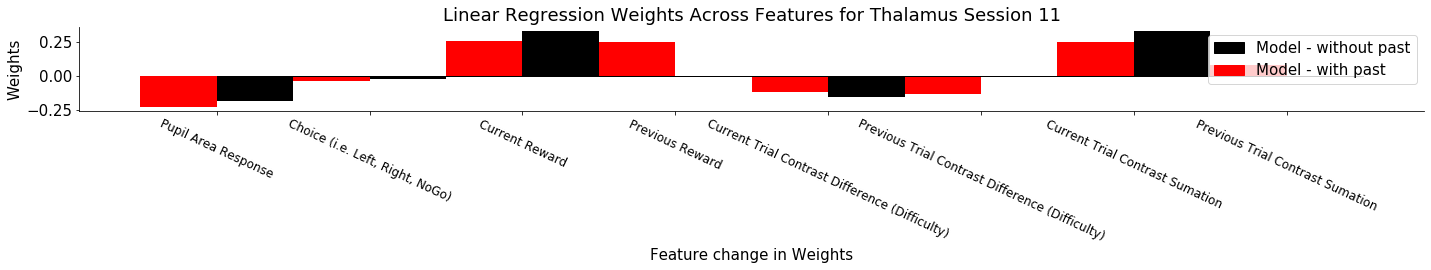

In [130]:
thalamus_coefficient_values_with_past = global_regression_with_past(11, 1, 'coefficient')

thalamus_pupil_area_with_past = thalamus_coefficient_values_with_past[0]
thalamus_choice_with_past = thalamus_coefficient_values_with_past[1]
thalamus_current_reward_with_past = thalamus_coefficient_values_with_past[2]
thalamus_past_reward_with_past = thalamus_coefficient_values_with_past[3]
thalamus_current_trial_contrast_difference_with_past = thalamus_coefficient_values_with_past[4]
thalamus_past_trial_contrast_difference_with_past = thalamus_coefficient_values_with_past[5]
thalamus_current_trial_contrast_sum_with_past = thalamus_coefficient_values_with_past[6]
thalamus_past_trial_contrast_sum_with_past = thalamus_coefficient_values_with_past[7]


thalamus_coefficient_values_without_past = global_regression_without_past(11, 1, 'coefficient')

thalamus_pupil_area_without_past = thalamus_coefficient_values_without_past[0]
thalamus_choice_without_past = thalamus_coefficient_values_without_past[1]
thalamus_current_reward_without_past = thalamus_coefficient_values_without_past[2]
thalamus_past_reward_without_past = 0
thalamus_current_trial_contrast_difference_without_past = thalamus_coefficient_values_without_past[3]
thalamus_past_trial_contrast_difference_without_past = 0
thalamus_current_trial_contrast_sum_without_past = thalamus_coefficient_values_without_past[4]
thalamus_past_trial_contrast_sum_without_past = 0


fig, ax = plt.subplots()
x = np.arange(len(names))

thalamus_values_with_past = [thalamus_pupil_area_with_past, thalamus_choice_with_past, thalamus_current_reward_with_past, thalamus_past_reward_with_past, thalamus_current_trial_contrast_difference_with_past, thalamus_past_trial_contrast_difference_with_past, thalamus_current_trial_contrast_sum_with_past, thalamus_past_trial_contrast_sum_with_past]
thalamus_values_without_past = [thalamus_pupil_area_without_past, thalamus_choice_without_past, thalamus_current_reward_without_past, thalamus_past_reward_without_past, thalamus_current_trial_contrast_difference_without_past, thalamus_past_trial_contrast_difference_without_past, thalamus_current_trial_contrast_sum_without_past, thalamus_past_trial_contrast_sum_without_past]

width =0.5
ax.bar(np.arange(len(thalamus_values_with_past))- width/2, thalamus_values_with_past, width=width, color='red')
ax.bar(np.arange(len(thalamus_values_without_past))+ width/2, thalamus_values_without_past, width=width, color='black')

#ax.bar(x, values_with_past, width=width, color='red')
#ax.bar(x + width, values_without_past, width=width, color='black')


names = ['Pupil Area Response', 'Choice (i.e. Left, Right, NoGo)', 'Current Reward', 'Previous Reward', 'Current Trial Contrast Difference (Difficulty)', 'Previous Trial Contrast Difference (Difficulty)', 'Current Trial Contrast Sumation', 'Previous Trial Contrast Sumation']

#def autolabel(rects):
#    """Attach a text label above each bar in *rects*, displaying its height."""
#    for rect in rects:
#        height = rect.get_height()
#        ax.annotate('{}'.format(height),
#                    xy=(rect.get_x() + rect.get_width() / 2, height),
#                    xytext=(0, 3),  # 3 points vertical offset
#                    textcoords="offset points",
#                    ha='center', va='bottom')
#autolabel(round(reacts1, 2))
#autolabel(round(reacts2, 2))


#plt.xticks(x, names, rotation=-20)
plt.xticks(x, names, rotation=-25, fontsize=12)

plt.title('Linear Regression Weights Across Features for Thalamus Session 11')
plt.xlabel('Feature change in Weights')
plt.ylabel('Weights')

X = [0,1,2,3,4,5,6,7,7.5]
Y = [0,0,0,0,0,0,0,0,0]
plt.plot(X,Y,c='black', linewidth=1)

red_patch = mpatches.Patch(color = 'red', label = 'Model - with past')
black_patch = mpatches.Patch(color = 'black', label = 'Model - without past')
plt.legend(handles = [black_patch, red_patch], loc='upper right')

#fig.tight_layout()

plt.show()

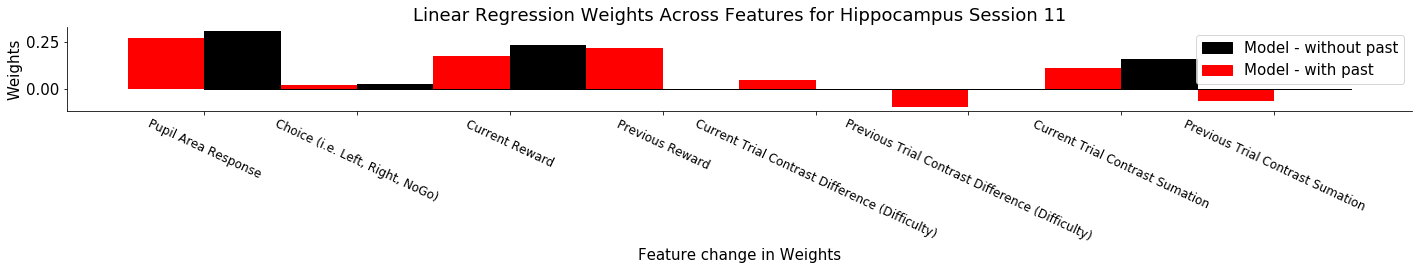

In [127]:
hippocampus_coefficient_values_with_past = global_regression_with_past(11, 2, 'coefficient')

hippocampus_pupil_area_with_past = hippocampus_coefficient_values_with_past[0]
hippocampus_choice_with_past = hippocampus_coefficient_values_with_past[1]
hippocampus_current_reward_with_past = hippocampus_coefficient_values_with_past[2]
hippocampus_past_reward_with_past = hippocampus_coefficient_values_with_past[3]
hippocampus_current_trial_contrast_difference_with_past = hippocampus_coefficient_values_with_past[4]
hippocampus_past_trial_contrast_difference_with_past = hippocampus_coefficient_values_with_past[5]
hippocampus_current_trial_contrast_sum_with_past = hippocampus_coefficient_values_with_past[6]
hippocampus_past_trial_contrast_sum_with_past = hippocampus_coefficient_values_with_past[7]


hippocampus_coefficient_values_without_past = global_regression_without_past(11, 2, 'coefficient')

hippocampus_pupil_area_without_past = hippocampus_coefficient_values_without_past[0]
hippocampus_choice_without_past = hippocampus_coefficient_values_without_past[1]
hippocampus_current_reward_without_past = hippocampus_coefficient_values_without_past[2]
hippocampus_past_reward_without_past = 0
hippocampus_current_trial_contrast_difference_without_past = hippocampus_coefficient_values_without_past[3]
hippocampus_past_trial_contrast_difference_without_past = 0
hippocampus_current_trial_contrast_sum_without_past = hippocampus_coefficient_values_without_past[4]
hippocampus_past_trial_contrast_sum_without_past = 0


fig, ax = plt.subplots()
x = np.arange(len(names))

hippocampus_values_with_past = [hippocampus_pupil_area_with_past, hippocampus_choice_with_past, hippocampus_current_reward_with_past, hippocampus_past_reward_with_past, hippocampus_current_trial_contrast_difference_with_past, hippocampus_past_trial_contrast_difference_with_past, hippocampus_current_trial_contrast_sum_with_past, hippocampus_past_trial_contrast_sum_with_past]
hippocampus_values_without_past = [hippocampus_pupil_area_without_past, hippocampus_choice_without_past, hippocampus_current_reward_without_past, hippocampus_past_reward_without_past, hippocampus_current_trial_contrast_difference_without_past, hippocampus_past_trial_contrast_difference_without_past, hippocampus_current_trial_contrast_sum_without_past, hippocampus_past_trial_contrast_sum_without_past]

width =0.5
ax.bar(np.arange(len(hippocampus_values_with_past))- width/2, hippocampus_values_with_past, width=width, color='red')
ax.bar(np.arange(len(hippocampus_values_without_past))+ width/2, hippocampus_values_without_past, width=width, color='black')

#ax.bar(x, values_with_past, width=width, color='red')
#ax.bar(x + width, values_without_past, width=width, color='black')


names = ['Pupil Area Response', 'Choice (i.e. Left, Right, NoGo)', 'Current Reward', 'Previous Reward', 'Current Trial Contrast Difference (Difficulty)', 'Previous Trial Contrast Difference (Difficulty)', 'Current Trial Contrast Sumation', 'Previous Trial Contrast Sumation']

#def autolabel(rects):
#    """Attach a text label above each bar in *rects*, displaying its height."""
#    for rect in rects:
#        height = rect.get_height()
#        ax.annotate('{}'.format(height),
#                    xy=(rect.get_x() + rect.get_width() / 2, height),
#                    xytext=(0, 3),  # 3 points vertical offset
#                    textcoords="offset points",
#                    ha='center', va='bottom')
#autolabel(round(reacts1, 2))
#autolabel(round(reacts2, 2))


#plt.xticks(x, names, rotation=-20)
plt.xticks(x, names, rotation=-25, fontsize=12)

plt.title('Linear Regression Weights Across Features for Hippocampus Session 11')
plt.xlabel('Feature change in Weights')
plt.ylabel('Weights')

X = [0,1,2,3,4,5,6,7,7.5]
Y = [0,0,0,0,0,0,0,0,0]
plt.plot(X,Y,c='black', linewidth=1)

red_patch = mpatches.Patch(color = 'red', label = 'Model - with past')
black_patch = mpatches.Patch(color = 'black', label = 'Model - without past')
plt.legend(handles = [black_patch, red_patch], loc='upper right')

#fig.tight_layout()

plt.show()

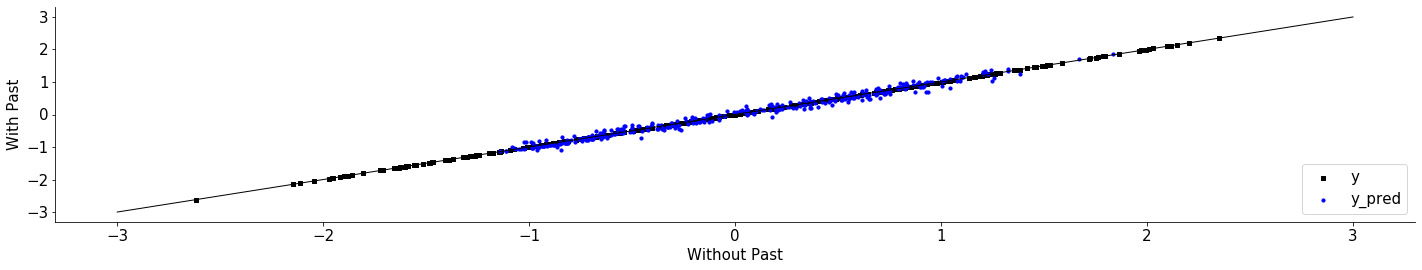

In [23]:
y_without_past = (global_regression_without_past(11, 0, 'y'))
y_pred_without_past = (global_regression_without_past(11, 0, 'y_pred'))
#without_past = (global_regression_without_past(11, 0, 'y'), global_regression_without_past(11, 0, 'y_pred'))

y_with_past = (global_regression_with_past(11, 0, 'y'))
y_pred_with_past = (global_regression_with_past(11, 0, 'y_pred'))
#with_past = (global_regression_with_past(11, 0, 'y'), global_regression_with_past(11, 0, 'y_pred'))

#data = (without_past, with_past)
color = ("black", "red")
groups = ("without past", "with past")

# Create plot
fig = plt.figure()
ax1 = fig.add_subplot(111)

#ax1.scatter(global_regression_without_past(11, 0, 'y'), global_regression_without_past(11, 0, 'y_pred'), s=10, c='k', marker="s", label='Without Past')
#ax1.scatter(global_regression_with_past(11, 0, 'y'), global_regression_with_past(11, 0, 'y_pred'), s=10, c='r', marker="o", label='With Past')
#alternative
ax1.scatter(global_regression_without_past(11, 0, 'y'), global_regression_with_past(11, 0, 'y'), s=10, c='k', marker="s", label='y')
ax1.scatter(global_regression_without_past(11, 0, 'y_pred'), global_regression_with_past(11, 0, 'y_pred'), s=10, c='b', marker="o", label='y_pred')

X = [-3,-2,-1,0,1,2,3]
Y = [-3,-2,-1,0,1,2,3]
plt.plot(X,Y,c='black', linewidth=1)

plt.xlabel('Without Past')
plt.ylabel('With Past')
plt.legend(loc='lower right')
plt.show()


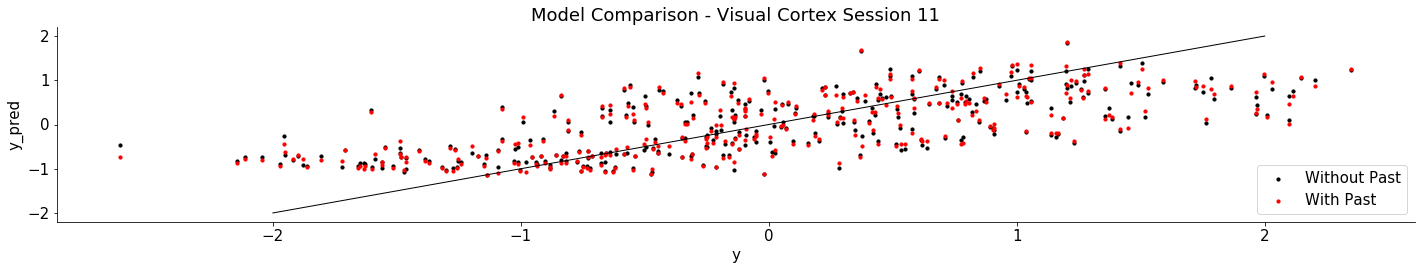

In [124]:
y_without_past = (global_regression_without_past(8, 0, 'y'))
y_pred_without_past = (global_regression_without_past(8, 0, 'y_pred'))
#without_past = (global_regression_without_past(11, 0, 'y'), global_regression_without_past(11, 0, 'y_pred'))

y_with_past = (global_regression_with_past(8, 0, 'y'))
y_pred_with_past = (global_regression_with_past(8, 0, 'y_pred'))
#with_past = (global_regression_with_past(11, 0, 'y'), global_regression_with_past(11, 0, 'y_pred'))

#data = (without_past, with_past)
color = ("black", "red")
groups = ("without past", "with past")

# Create plot
fig = plt.figure()
ax1 = fig.add_subplot(111)

plot_without_past = ax1.scatter(global_regression_without_past(11, 0, 'y'), global_regression_without_past(11, 0, 'y_pred'), s=10, c='k', marker="o", label='Without Past')
plot_with_past = ax1.scatter(global_regression_with_past(11, 0, 'y'), global_regression_with_past(11, 0, 'y_pred'), s=10, c='r', marker="o", label='With Past')
#alternative
#ax1.scatter(global_regression_without_past(11, 0, 'y'), global_regression_with_past(11, 0, 'y'), s=10, c='k', marker="s", label='y')
#ax1.scatter(global_regression_without_past(11, 0, 'y_pred'), global_regression_with_past(11, 0, 'y_pred'), s=10, c='r', marker="o", label='y_pred')

#without_past_fit = np.polyfit(global_regression_without_past(11, 0, 'y'), global_regression_without_past(11, 0, 'y_pred'),1)
#with_past_fit = np.polyfit(global_regression_with_past(11, 0, 'y'), global_regression_with_past(11, 0, 'y_pred'),1)

#p1 = np.poly1d(without_past_fit)
#p2 = np.poly1d(with_past_fit)
#plt.plot(without_past_fit, p1(without_past_fit),"k--")
#plt.plot(with_past_fit, p1(with_past_fit),"r--")

#plt.plot(without_past_fit)
#plt.plot(with_past_fit)


X = [-2,-1,0,1,2]
Y = [-2,-1,0,1,2]
plt.plot(X,Y,c='black', linewidth=1)

plt.title('Model Comparison - Visual Cortex Session 11')
plt.xlabel('y')
plt.ylabel('y_pred')
plt.legend(loc='lower right')
plt.show()

#plot each fit

Text(0, 0.5, 'y_pred')

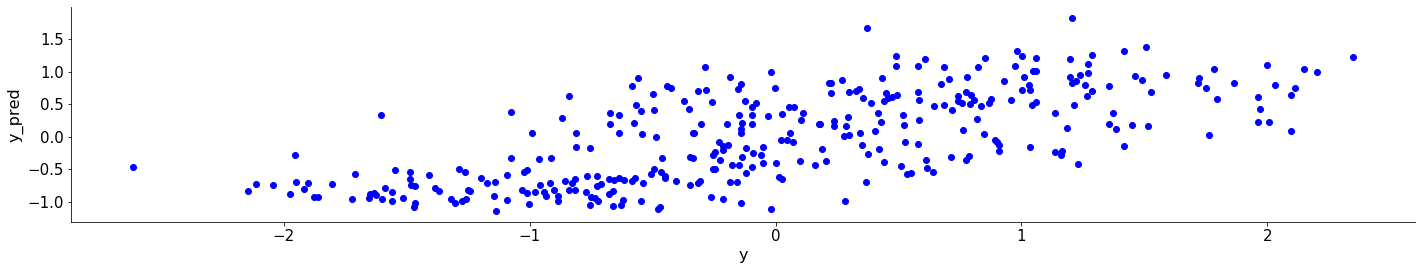

In [26]:
y = (global_regression_without_past(11, 0, 'y'))
y_pred = (global_regression_without_past(11, 0, 'y_pred'))

#weight=np.concatenate((weight1,weight2,weight3))
#height=np.concatenate((height1,height2,height3))

plt.scatter(y,y_pred,c='b',marker='o')
plt.xlabel('y', fontsize=16)
plt.ylabel('y_pred', fontsize=16)

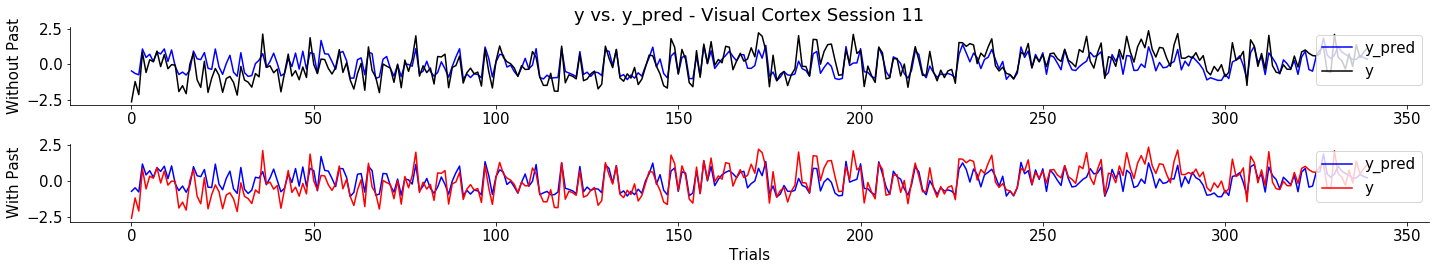

In [131]:
fig, axs = plt.subplots(2)
axs[0].plot(global_regression_without_past(11, 0, 'y_pred'), color = 'b', label='y_pred')
axs[0].plot(global_regression_without_past(11, 0, 'y'), color = 'k', label='y')
axs[0].set_title('y vs. y_pred - Visual Cortex Session 11')
axs[0].set_ylabel('Without Past')
axs[0].legend(loc="upper right")

axs[1].plot(global_regression_with_past(11, 0, 'y_pred'), color = 'b', label='y_pred')
axs[1].plot(global_regression_with_past(11, 0, 'y'), color = 'r', label='y')
axs[1].set_ylabel('With Past')
axs[1].set_xlabel('Trials')
axs[1].legend(loc="upper right")

#axs[3].plot(global_regression_with_past(11, 0, 'y_pred'), color = 'b', label='y_pred with past')
#axs[3].plot(global_regression_without_past(11, 0, 'y_pred'), color = 'r', label='y_pred without past')
#axs[3].set_ylabel('With Past')
#axs[3].set_xlabel('Trials')
#axs[3].legend(loc="upper right")

#axs[3].xcorr(global_regression_without_past(11, 0, 'y_pred'), global_regression_with_past(11, 0, 'y_pred'))
#plt.plot()

#something wrong with printing the y_pred?

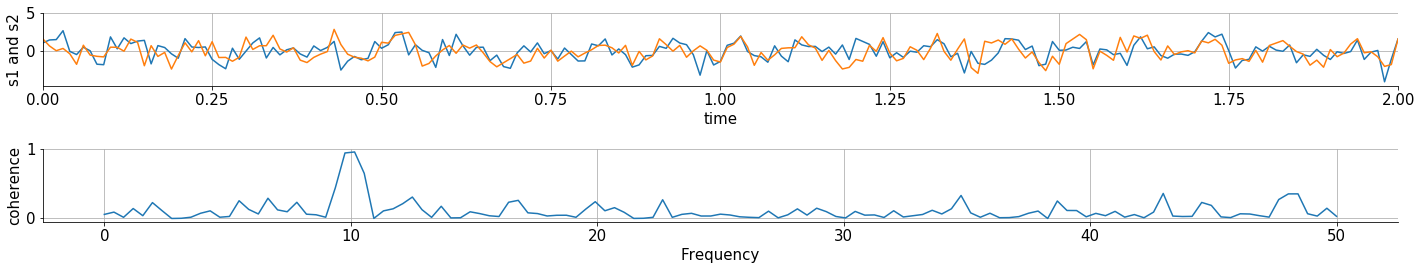

In [28]:
#plot coherence

# Fixing random state for reproducibility
np.random.seed(19680801)

dt = 0.01
t = np.arange(0, 30, dt)
nse1 = np.random.randn(len(t))                 # white noise 1
nse2 = np.random.randn(len(t))                 # white noise 2

# Two signals with a coherent part at 10Hz and a random part
s1 = np.sin(2 * np.pi * 10 * t) + nse1
s2 = np.sin(2 * np.pi * 10 * t) + nse2

fig, axs = plt.subplots(2, 1)
axs[0].plot(t, s1, t, s2)
axs[0].set_xlim(0, 2)
axs[0].set_xlabel('time')
axs[0].set_ylabel('s1 and s2')
axs[0].grid(True)

cxy, f = axs[1].cohere(s1, s2, 256, 1. / dt)
axs[1].set_ylabel('coherence')

fig.tight_layout()
plt.show()

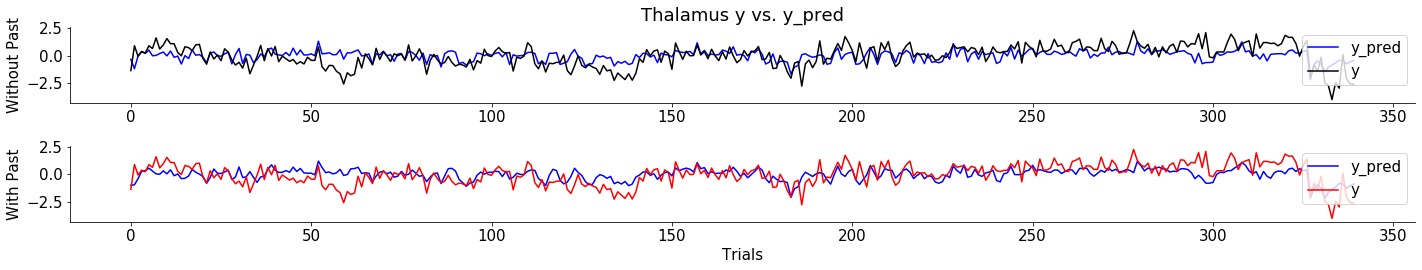

In [32]:
fig, axs = plt.subplots(2)
axs[0].plot(global_regression_without_past(11, 1, 'y_pred'), color = 'b', label='y_pred')
axs[0].plot(global_regression_without_past(11, 1, 'y'), color = 'k', label='y')
axs[0].set_title('Thalamus y vs. y_pred')
axs[0].set_ylabel('Without Past')
axs[0].legend(loc="upper right")

axs[1].plot(global_regression_with_past(11, 1, 'y_pred'), color = 'b', label='y_pred')
axs[1].plot(global_regression_with_past(11, 1, 'y'), color = 'r', label='y')
axs[1].set_ylabel('With Past')
axs[1].set_xlabel('Trials')
axs[1].legend(loc="upper right")

#plt.plot()

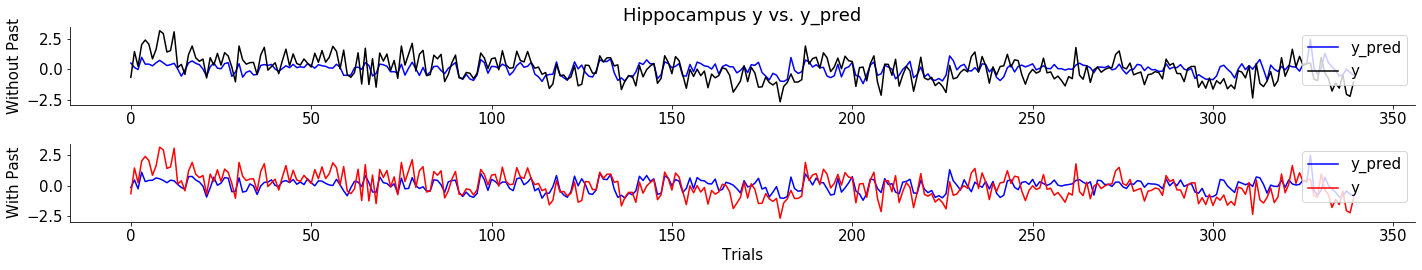

In [31]:
fig, axs = plt.subplots(2)
axs[0].plot(global_regression_without_past(11, 2, 'y_pred'), color = 'b', label='y_pred')
axs[0].plot(global_regression_without_past(11, 2, 'y'), color = 'k', label='y')
axs[0].set_title('Hippocampus y vs. y_pred')
axs[0].set_ylabel('Without Past')
axs[0].legend(loc="upper right")

axs[1].plot(global_regression_with_past(11, 2, 'y_pred'), color = 'b', label='y_pred')
axs[1].plot(global_regression_with_past(11, 2, 'y'), color = 'r', label='y')
axs[1].set_ylabel('With Past')
axs[1].set_xlabel('Trials')
axs[1].legend(loc="upper right")

#plt.plot()

AttributeError: 'numpy.ndarray' object has no attribute 'plot'

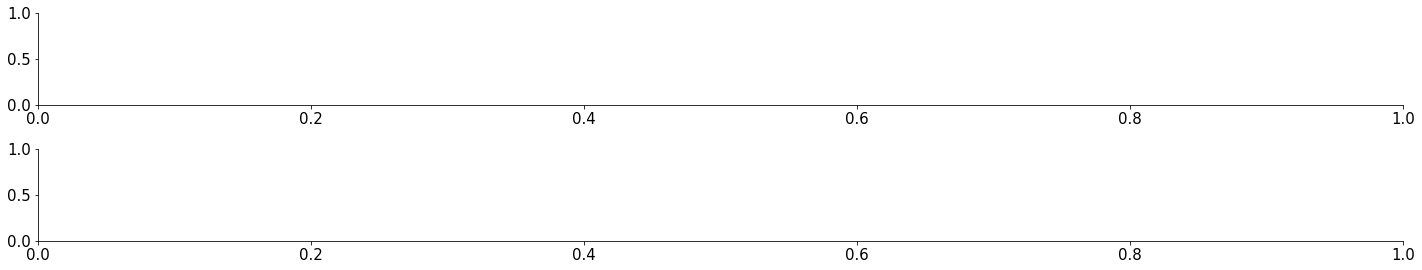

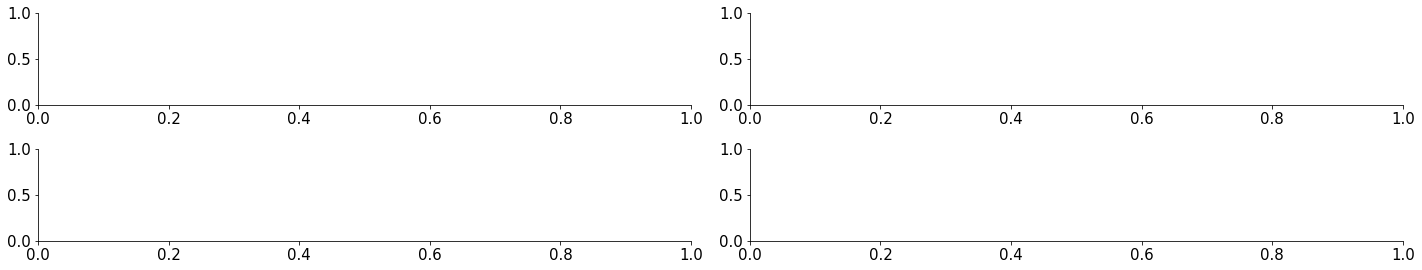

In [34]:
#Visual Cortex y vs y_pred w/o Past
#average y values and make sub plots
#pot for with past

fig, axs = plt.subplots(2)
fig, axs = plt.subplots(2, 2)
axs[0].plot(global_regression_without_past(11, 0, 'y_pred'), color = 'b')
axs[0].plot(global_regression_without_past(11, 0, 'y'), color = 'k')
axs[0].set_title('Visual Cortex y vs y_pred w/o Past')
axs[1].plot(global_regression_without_past(11, 0, 'y_pred'), color = 'b')
axs[1].plot(global_regression_without_past(11, 0, 'y_pred'), color = 'r')
axs[1].set_title('Visual Cortex y vs y_pred w/ Past')

plt.plot(global_regression_without_past(11, 0, 'y_pred'), color = 'b')
plt.plot(global_regression_without_past(11, 0, 'y'), color = 'k')
#plt.title('Visual Cortex y vs y_pred w/o Past')
#ax.set(xlabel = 'Trial', ylabel = 'mean firing rate (Hz)', title = 'Visual Cortex y vs y_pred W/ Past')
plt.xlabel('Trials')
plt.ylabel('Average Response')
plt.show()

#Thalamus y vs y_pred w/o Past
plt.plot(global_regression_without_past(11, 1, 'y_pred'), color = 'b')
plt.plot(global_regression_without_past(11, 1, 'y'), color = 'k')
plt.title('Thalamus y vs y_pred w/o Past')
plt.xlabel('Trials')
plt.ylabel('Average Response')
plt.show()

#hippocampus y vs y_pred w/o Past
plt.plot(global_regression_without_past(11, 2, 'y_pred'), color = 'b')
plt.plot(global_regression_without_past(11, 2, 'y'), color = 'k')
plt.title('Hipppocampus y vs y_pred w/o Past')
plt.xlabel('Trials')
plt.ylabel('Average Response')
plt.show()

#Other Cortex y vs y_pred w/o Past
plt.plot(global_regression_without_past(11, 3, 'y_pred'), color = 'b')
plt.plot(global_regression_without_past(11, 3, 'y'), color = 'k')
plt.title('Other Cortex y vs y_pred w/o Past')
plt.xlabel('Trials')
plt.ylabel('Average Response')
plt.show()

#plt.plot(global_regression_without_past(11, 4, 'y_pred'))
#global_regression_without_past(11, 0, 'r_sq')

In [61]:
#work in progress for **keys**
import matplotlib.patches as mpatches
def plot_r_sq_hist(session, key):
    def with_past(session):
        vis_ctx_with_past = global_regression_with_past(session, 0, 'r_sq')
        thalamus_with_past = global_regression_with_past(session, 1, 'r_sq')
        hippocampus_with_past = global_regression_with_past(session, 2, 'r_sq')
        other_ctx_with_past = global_regression_with_past(session, 3, 'r_sq')

        with_past_values = [vis_ctx_with_past, thalamus_with_past, hippocampus_with_past, other_ctx_with_past]
        names = ['vis_ctx', 'thalamus', 'hippocampus', 'other_ctx']
        
        return with_past_values
    
    def without_past(session):
        vis_ctx_without_past = global_regression_without_past(session, 0, 'r_sq')
        thalamus_without_past = global_regression_without_past(session, 1, 'r_sq')
        hippocampus_without_past = global_regression_without_past(session, 2, 'r_sq')
        other_ctx_without_past = global_regression_without_past(session, 3, 'r_sq')

        without_past_values = [vis_ctx_without_past, thalamus_without_past, hippocampus_without_past, other_ctx_without_past]
        names = ['vis_ctx', 'thalamus', 'hippocampus', 'other_ctx']
    
        return without_past_values
    
    names = ['vis_ctx', 'thalamus', 'hippocampus', 'other_ctx']
    x = np.arange(len(without_past(session)))

    bar_width = 0.3
    plt.bar(x, with_past(session), width=bar_width, color='red')
    plt.bar(x + bar_width, without_past(session), width=bar_width, color='black')

    plt.xticks(x, names)
    #plt.xticks(x + bar_width, names)
    plt.title('Regional r_sq Value Across Regions w/ Past')
    plt.xlabel('Brain Regions')
    plt.ylabel('r_sq value')

    #plt.errorbar(x, y, e, linestyle='None', marker='^')

    red_patch = mpatches.Patch(color = 'red', label = with_past(session))
    black_patch = mpatches.Patch(color = 'black', label = without_past(session))
    plt.legend(handles = [black_patch, red_patch])
    plt.show()

In [ ]:
def plot_observed_vs_predicted_with_past(session, region):
    i = session
    r = region
    X = polynomialregression_with_past(11, 0, 'X_')
    y = y_variables_across_all_sessions(11, 0)
    y_pred = polynomialregression_with_past(11, 0, 'y_pred')
    fig, ax = plt.subplots()
    ax.scatter(X, y, label='Observed')  # our data scatter plot
    ax.scatter(X, y)  # our data scatter plot
    ax.plot(X, y_pred, color='r', label='Fit')  # our estimated model
    ax.plot(X, y_pred, color='r')  # our estimated model
    # plot residuals
    ymin = np.minimum(y, y_pred)
    ymax = np.maximum(y, y_pred)
    ax.vlines(x, ymin, ymax, 'g', alpha=0.5, label='Residuals')
    ax.set(
      #title=fr"$\hat{{\theta}}$ = {theta_hat:0.2f}, MSE = {mse(x, y, theta_hat):.2f}",
      xlabel='x',
      ylabel='y'
    )
    ax.legend()

#plot_observed_vs_predicted_with_past(11, 0)

# Plot: mean firing rate vs task difficulty

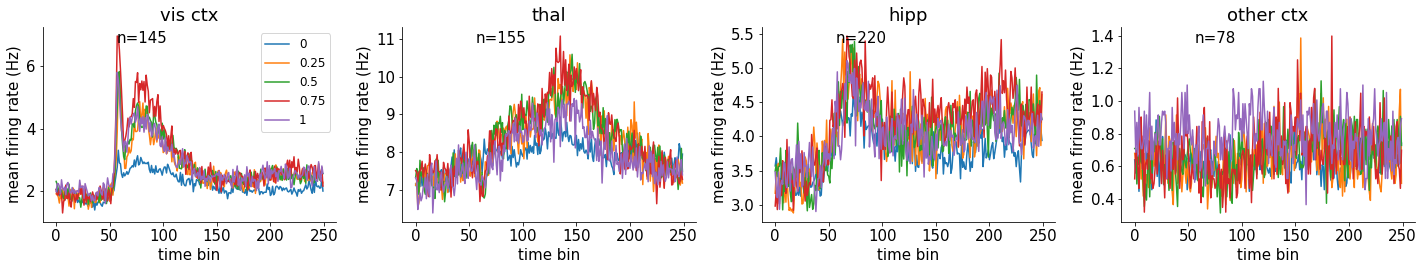

In [62]:
dt = dat['bin_size'] # binning at 10 ms
NT = dat['spks'].shape[-1]

l_cont = dat['contrast_left']
r_cont = dat['contrast_right']
    
for j in range(nareas):
    ax = plt.subplot(1,nareas,j+1)
    
    plt.plot(np.arange(NT), 1/dt * dat['spks'][:,(np.abs(l_cont-r_cont))==0][barea==j].mean(axis=(0,1))) # difference 0
    plt.plot(np.arange(NT), 1/dt * dat['spks'][:,np.abs(l_cont-r_cont)==0.25][barea==j].mean(axis=(0,1))) # difference 0.25
    plt.plot(np.arange(NT), 1/dt * dat['spks'][:,np.abs(l_cont-r_cont)==0.5][barea==j].mean(axis=(0,1))) # difference 0.5
    plt.plot(np.arange(NT), 1/dt * dat['spks'][:,np.abs(l_cont-r_cont)==0.75][barea==j].mean(axis=(0,1))) # difference 0.75
    plt.plot(np.arange(NT), 1/dt * dat['spks'][:,np.abs(l_cont-r_cont)==1][barea==j].mean(axis=(0,1))) # difference 1
  
    plt.text(.25, .92, 'n=%d'%np.sum(barea==j), transform=ax.transAxes)

    if j==0:
        plt.legend(['0', '0.25', '0.5', '0.75', '1'], fontsize=12)
    ax.set(xlabel = 'time bin', ylabel = 'mean firing rate (Hz)', title = regions[j])
hide_toggle()